In [85]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [86]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [87]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [96]:
def remove_unused_columns(df):
    df = df.pop('wind_speed_10m:ms')
    #df = df.pop('pressure_100m:hPa')
    #df = df.pop('pressure_50m:hPa')

In [89]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in train.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    for key in constanst_columns:
        if val.std()[key] != 0.0 or test.std()[key] != 0.0:
            constanst_columns.remove(key)

    for key in constanst_columns:
        train = train.drop([key], axis=1)
        val = val.drop([key], axis=1)
        test = test.drop([key], axis=1)

In [90]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60
    year = (365.2425)*day
    month = year / 12.0

    date_time = pd.to_datetime(df.pop('date'), format='%Y-%m.%d %H:%M:%S')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [91]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]

In [92]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

In [93]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [94]:
# Join data and labels into one df
train_data_a, val_data_a = join_data_and_labels(X_train_observed_a, X_train_estimated_a, train_a)
train_data_b, val_data_b = join_data_and_labels(X_train_observed_b, X_train_estimated_b, train_b)
train_data_c, val_data_c = join_data_and_labels(X_train_observed_c, X_train_estimated_c, train_c)

In [95]:
# Remove columns which are not needed
remove_unused_columns(train_data_a)
remove_unused_columns(val_data_a)
remove_unused_columns(test_a)

remove_unused_columns(train_data_b)
remove_unused_columns(val_data_b)
remove_unused_columns(test_b)

remove_unused_columns(train_data_c)
remove_unused_columns(val_data_c)
remove_unused_columns(test_c)

KeyError: 'pressure_50m:hPa'

In [ ]:
# Drop columns which are constant
drop_constanst_columns(train_data_a, val_data_a, test_a)
drop_constanst_columns(train_data_b, val_data_b, test_b)
drop_constanst_columns(train_data_c, val_data_c, test_c)

In [ ]:
# Convert date into sin and cos components
convert_date_to_sin_and_cos(train_data_a)
convert_date_to_sin_and_cos(val_data_a)
convert_date_to_sin_and_cos(test_a)

convert_date_to_sin_and_cos(train_data_b)
convert_date_to_sin_and_cos(val_data_b)
convert_date_to_sin_and_cos(test_b)

convert_date_to_sin_and_cos(train_data_c)
convert_date_to_sin_and_cos(val_data_c)
convert_date_to_sin_and_cos(test_c)

In [ ]:
# Isday should be a binary value
round_is_day(train_data_a)
round_is_day(val_data_a)
round_is_day(test_a)

round_is_day(train_data_b)
round_is_day(val_data_b)
round_is_day(test_b)

round_is_day(train_data_c)
round_is_day(val_data_c)
round_is_day(test_c)

In [ ]:
# Fill 0 for NaNs
train_data_a = train_data_a.fillna(0)
val_data_a = val_data_a.fillna(0)
test_a = test_a.fillna(0)

train_data_b = train_data_b.fillna(0)
val_data_b = val_data_b.fillna(0)
test_b = test_b.fillna(0)

train_data_c = train_data_c.fillna(0)
val_data_c = val_data_c.fillna(0)
test_c = test_c.fillna(0)

In [ ]:
train_data_a.head().transpose()

In [56]:
MAX_EPOCHS = 20

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [57]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [58]:
def batch(df):
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [59]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [60]:
train_a_max = train_a_y.max()
train_a_y = train_a_y / train_a_max
val_a_y = val_a_y / train_a_max

train_b_max = train_b_y.max()
train_b_y = train_b_y / train_b_max
val_b_y = val_b_y / train_b_max

train_c_max = train_c_y.max()
train_c_y = train_c_y / train_c_max
val_c_y = val_c_y / train_c_max

In [61]:
lstm_model_a = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False),
    
    tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(units=48),
    tf.keras.layers.Dense(units=32),

    tf.keras.layers.Dense(units=1, activation="relu")
])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [62]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

Epoch 1/20
31/31 [==============================] - 28s 291ms/step - loss: 0.0331 - mean_absolute_error: 0.1073 - val_loss: 0.0136 - val_mean_absolute_error: 0.0553
Epoch 2/20
31/31 [==============================] - 3s 108ms/step - loss: 0.0197 - mean_absolute_error: 0.0787 - val_loss: 0.0096 - val_mean_absolute_error: 0.0432
Epoch 3/20
31/31 [==============================] - 3s 108ms/step - loss: 0.0164 - mean_absolute_error: 0.0683 - val_loss: 0.0078 - val_mean_absolute_error: 0.0382
Epoch 4/20
31/31 [==============================] - 3s 108ms/step - loss: 0.0152 - mean_absolute_error: 0.0655 - val_loss: 0.0076 - val_mean_absolute_error: 0.0365
Epoch 5/20
31/31 [==============================] - 3s 108ms/step - loss: 0.0158 - mean_absolute_error: 0.0670 - val_loss: 0.0083 - val_mean_absolute_error: 0.0389
Epoch 6/20
31/31 [==============================] - 3s 109ms/step - loss: 0.0147 - mean_absolute_error: 0.0635 - val_loss: 0.0071 - val_mean_absolute_error: 0.0349
Epoch 7/20
31/3

In [63]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

Epoch 1/20
31/31 [==============================] - 27s 247ms/step - loss: 0.0204 - mean_absolute_error: 0.0806 - val_loss: 0.0077 - val_mean_absolute_error: 0.0429
Epoch 2/20
31/31 [==============================] - 3s 107ms/step - loss: 0.0147 - mean_absolute_error: 0.0650 - val_loss: 0.0069 - val_mean_absolute_error: 0.0352
Epoch 3/20
31/31 [==============================] - 3s 107ms/step - loss: 0.0138 - mean_absolute_error: 0.0621 - val_loss: 0.0062 - val_mean_absolute_error: 0.0342
Epoch 4/20
31/31 [==============================] - 3s 107ms/step - loss: 0.0129 - mean_absolute_error: 0.0598 - val_loss: 0.0067 - val_mean_absolute_error: 0.0343
Epoch 5/20
31/31 [==============================] - 3s 108ms/step - loss: 0.0126 - mean_absolute_error: 0.0589 - val_loss: 0.0058 - val_mean_absolute_error: 0.0353
Epoch 6/20
31/31 [==============================] - 3s 106ms/step - loss: 0.0125 - mean_absolute_error: 0.0590 - val_loss: 0.0062 - val_mean_absolute_error: 0.0362
Epoch 7/20
31/3

In [64]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

Epoch 1/20
31/31 [==============================] - 30s 299ms/step - loss: 0.0288 - mean_absolute_error: 0.0663 - val_loss: 0.0130 - val_mean_absolute_error: 0.0410
Epoch 2/20
31/31 [==============================] - 4s 114ms/step - loss: 0.0287 - mean_absolute_error: 0.0653 - val_loss: 0.0130 - val_mean_absolute_error: 0.0410
Epoch 3/20
4/4 [==============================] - 0s 32ms/step - loss: 0.0130 - mean_absolute_error: 0.0410
measure c: [0.013048933818936348, 0.04095209389925003]


In [69]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

1/1 [==============================] - 0s 105ms/step


In [67]:
pred_a = pred_a.flatten() * train_a_max
pred_b = pred_b.flatten() * train_b_max
pred_c = pred_c.flatten() * train_c_max

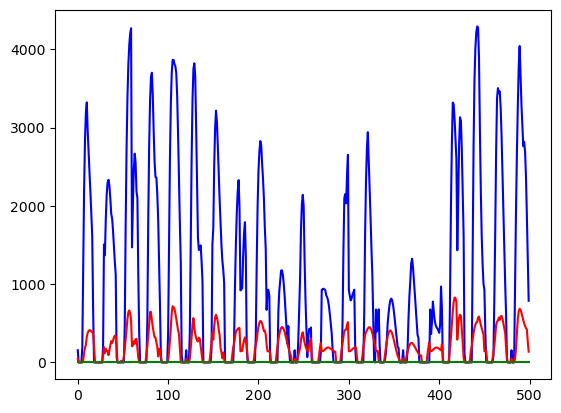

In [68]:
plt.plot(pred_a[0:500], color="blue")
plt.plot(pred_b[0:500], color="red")
plt.plot(pred_c[0:500], color="green")

In [33]:
len(pred_a)

720

In [34]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [35]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [36]:
submit = np.concatenate((np.concatenate((pred_a, pred_b)),pred_c))

In [37]:
# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)